# Scientific Computing Course | Final Project
by Millis Sahar, ID300420379


<br><br><br><br>
<a href='https://www.loom.com/share/43a3389f79714944bb0a7c2460859e59'>link</a> to video presentation.
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>


# Goals

#### Goal #1 - Achived!
Train a NN to fit a Gaussian/Normal distribution using GAN architecture (discriminator & generator).

<div>
<img src="https://miro.medium.com/max/600/1*2SeShyA4HGzmHyXqWxCUbQ.gif" width="400"/>
</div>

##### Goal #2 - Achived!
Train a NN to fit the MNIST dataset using GAN architecture.


<div>
<img src="https://miro.medium.com/max/640/1*mVEtS64T4ShRYWSM5xZ9XQ.gif" width="500"/>
</div>


##### Goal #3 - Partially Achieved!
Train a NN to fit the Predator-Prey cycle using GAN architecture.

<div>
<img src="https://www.macs.hw.ac.uk/~jas/researchinterests/images/pp_animation.gif" width="500"/>
</div>

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

## Notebook Edit Helpers

Disabling autoscrolling for long output:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

# GAN Architecture

A generative adversarial network is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. Two neural networks contest with each other in a game. Given a training set, this technique learns to generate new data with the same statistics as the training set. 

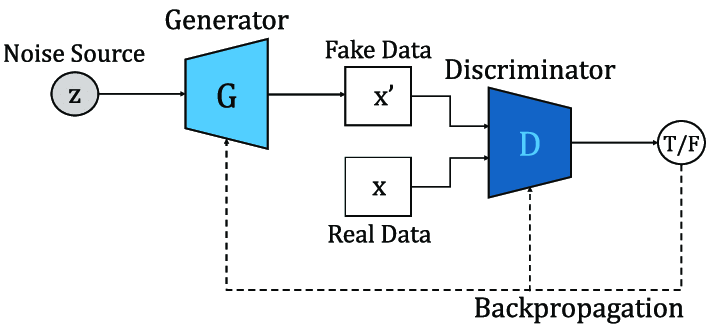

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

# Goal #1 - Gaussian/Normal distribution

Train a NN to fit a Gaussian/Normal distribution using GAN architecture (discriminator & generator).

##### imports

In [12]:
import numpy as np

import torch
from torch import nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.animation

from time import time
from IPython.display import display, clear_output

##### Generator

In [13]:
class Generator_distribution(nn.Module):
    def __init__(self,input_dim=1):
        # initialize nn Module
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        # architecture
        self.layers.append(nn.Linear(input_dim,64))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(32,1))
        
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        return x
    
yoyo = Generator_distribution()
yoyo.forward(torch.rand(10,1))

tensor([[-0.2973],
        [-0.3088],
        [-0.2975],
        [-0.2974],
        [-0.3010],
        [-0.3098],
        [-0.3049],
        [-0.2977],
        [-0.2988],
        [-0.2975]], grad_fn=<AddmmBackward>)

#### Discriminator

In [14]:
class Discriminator_distribution(nn.Module):
    def __init__(self,input_dim=1):
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        self.layers.append(nn.Linear(input_dim,64))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(64,32))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.Linear(32,1))
        self.layers.append(nn.Sigmoid())
    
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        return x

yoyo = Discriminator_distribution(input_dim=1)
yoyo.forward(torch.rand(10,1))

tensor([[0.4804],
        [0.4798],
        [0.4799],
        [0.4807],
        [0.4950],
        [0.4804],
        [0.4890],
        [0.4803],
        [0.4832],
        [0.4814]], grad_fn=<SigmoidBackward>)

#### Gan

In [15]:
class GAN_distribution():
    def __init__(self,batch_size=10,n_epochs=600,lr_generator=0.0001,lr_discriminator=0.0004,from_dist=torch.rand,to_dist=torch.randn):
        
        # models
        self.generator     = Generator_distribution()
        self.discriminator = Discriminator_distribution()
        
        # criterion
        self.criterion = nn.BCELoss()
        
        # optimizers
        self.optim_generator     = optim.Adam(self.generator.parameters(),    lr=lr_generator)
        self.optim_discriminator = optim.Adam(self.discriminator.parameters(),lr=lr_discriminator)
        
        # distrebutions from & to
        self.initial = from_dist
        self.real    = to_dist
        
        # batch
        self.batch_size = batch_size
            
        # epochs    
        self.n_epochs=n_epochs

        # helper for loss
        self.ones = torch.ones((batch_size, 1))
        self.zeros = torch.zeros((batch_size, 1))
        
        
    def sample_gen(self,num=1000):
        with torch.no_grad():
                return self.generator(self.initial((num,1)))
     
    
    def train_step(self):
        loss_discriminator = self.train_step_discriminator()
        loss_generator = self.train_step_generator()
        return loss_generator,loss_discriminator
   
    
    def train_step_generator(self):
        
        self.generator.zero_grad()
        
        # gen
        sample = self.initial((self.batch_size,1))
        gen = self.generator(sample)
        cls = self.discriminator(gen)
        
        # adjusting the gen's Ws in order to fool the discriminator
        loss = self.criterion(cls,self.ones)
        loss.backward()
        self.optim_generator.step()
        return loss.item()
    
    
    def train_step_discriminator(self):
        
        self.discriminator.zero_grad()
        
        # real
        sample = self.real((self.batch_size,1))
        pred_real = self.discriminator(sample)
        loss_real = self.criterion(pred_real,self.ones)
        
        # gen
        sample = self.initial((self.batch_size,1))
        with torch.no_grad():
            gen = self.generator(sample)
        pred_fake = self.discriminator(gen)
        loss_fake = self.criterion(pred_fake,self.zeros)
        
        # combine losses
        loss = (loss_real + loss_fake)/2
        loss.backward()
        self.optim_discriminator.step()
        return loss_real.item(),loss_fake.item()

    
    def train(self,verbose_instead_of_animation=False):
        self.loss_g, self.loss_d_real, self.loss_d_fake = [], [], []

        self.samples = []
        start = time()
        for epoch in range(self.n_epochs):
            
            loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
            
            for batch in range(self.batch_size):
                lg_, (ldr_, ldf_) = self.train_step()
                loss_g_running += lg_
                loss_d_real_running += ldr_
                loss_d_fake_running += ldf_
            
            self.loss_g.append(loss_g_running / self.batch_size)
            self.loss_d_real.append(loss_d_real_running / self.batch_size)
            self.loss_d_fake.append(loss_d_fake_running / self.batch_size)
            self.samples.append(self.sample_gen())
            
            if verbose_instead_of_animation and ((epoch+1)%100==0):
                print(f"Epoch {epoch+1}/{self.n_epochs} ({int(time() - start)}s):"
                      f" G={self.loss_g[-1]:.3f},"
                      f" Dr={self.loss_d_real[-1]:.3f},"
                      f" Df={self.loss_d_fake[-1]:.3f}")
        
        if not verbose_instead_of_animation:
            self.plot_animation()
        
    
    def plot(self,num=100):
        fig, ax = plt.subplots(1,2,figsize=(18,6))

        # plot Loss
        ax[0].plot(self.loss_g,label='Generator Loss')
        ax[0].plot(self.loss_d_real,label='Discriminator Loss on Real data')
        ax[0].plot(self.loss_d_fake,label='Discriminator Loss on Fake data')
        ax[0].set_title('Loss')
        ax[0].legend()

        # plot distribution
        arr = self.sample_gen(num=num).detach().numpy()
        sns.distplot(self.real(num),label='Real',hist_kws=dict(alpha=1),ax=ax[1])
        sns.distplot(arr,label='GAN',hist_kws=dict(alpha=0.5),ax=ax[1])
        ax[1].set_title('Distributions')
        ax[1].legend()
        
    def plot_animation(self):
        fig, ax = plt.subplots(1,2,figsize=(18,6))
        
        # Plot Loss
        l, = ax[0].plot([0,10],[0,2])
        l2, = ax[0].plot([0,10],[0,2])
        l3, = ax[0].plot([0,10],[0,2])
        ax[0].legend(['Generator Loss','Discriminator Loss on Real data','Discriminator Loss on Fake data'])
        ax[0].set_title('Loss')

        # Plot loss - animations functions
        t = np.arange(len(self.loss_g))
        animate_g = lambda i: l.set_data(t[:i], self.loss_g[:i])
        animate_d_real = lambda i: l2.set_data(t[:i], self.loss_d_real[:i])
        animate_d_fake = lambda i: l3.set_data(t[:i], self.loss_d_fake[:i])
        
        # Plot distribution
        num = len(self.samples[0])
        real_ = self.real(num)
        fake_ = [np.array(s) for s in self.samples]
        
        # Plot distribution - animation function
        def animate_samples(i):
            ax[1].clear();
            sns.distplot(real_,label='Real',hist_kws=dict(alpha=1),ax=ax[1])
            sns.distplot(fake_[i],label='GAN',hist_kws=dict(alpha=0.5),ax=ax[1])
            ax[1].legend()
            ax[1].set_title('Distributions')

            
        # Plot each epoch - Loss & distribution
        for i in range(self.n_epochs):
            # call animation functions
            animate_g(i)
            animate_d_real(i)
            animate_d_fake(i)
            animate_samples(i)
            
            # clear output anf dislay figure
            clear_output(wait=True)
            display(fig)
            
            # Plot Loss - scale the plot by new values
            ax[0].relim()
            ax[0].autoscale_view(True,True)
            
            # Plot distribution - scale the plot by new values
            ax[1].relim()
            ax[1].autoscale_view(True,True)
            
            # show entire plot
            plt.show()

##### Train & Visualize

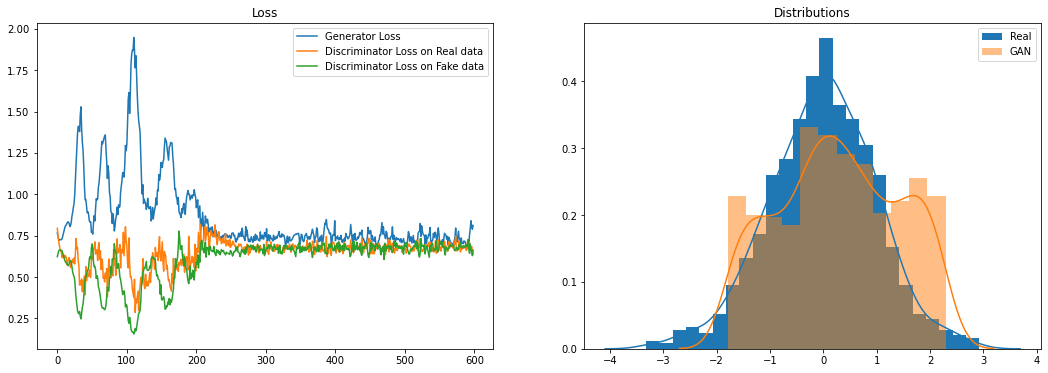

In [16]:
gan = GAN_distribution()
gan.train()

#### Generate

<AxesSubplot:>

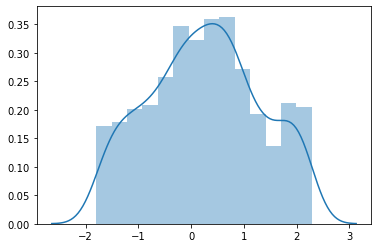

In [17]:
sns.distplot(gan.sample_gen())

In [28]:
# Free GPU memory
del gan
torch.cuda.empty_cache()

#### Closing Thoughts
This implementation was about getting **femiliar with the GAN**:
* Architecture  
* General Flow  
* Training loop  
* Visualization  


While doing this in **PyTorch**.<br>
Actually, "little thought" was given to the actual network layers and activation functions.

Also, I obviously know that I typically won't have access to the true data-generating distribution. Because if I did, I wouldn’t need a GAN!

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

# Goal #2 - MNIST dataset
Train a NN to fit the MNIST dataset using GAN architecture.

#### imports

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


import matplotlib.pylab as plt
from matplotlib import gridspec
import matplotlib.animation
from IPython.display import display, clear_output

#### Device - GPU / CPU

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

#### Hyper-Parameters

In [3]:
# Params
LATENT_SIZE = 64
HIDDEN_SIZE = 256
IMAGE_SIZE = 784
NUM_EPOCHS = 300
BATCH_SIZE = 32

# criterion
criterion = nn.BCELoss()

# Learning Rates
lr_generator     = 0.0001
lr_discriminator = 0.0004

#### Download MNIST

In [4]:
# tranfor to tensor
train_transform = transforms.Compose([transforms.ToTensor()])

# download dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, download=True,transform=train_transform)

# Normelize - same as torchvision.transforms.Normalize()
mean = train_dataset.data.numpy().mean()/255
std = train_dataset.data.numpy().std()/255
train_dataset.data = (train_dataset.data - torch.tensor(mean))/torch.tensor(std)

# use dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Generator

In [5]:
class Generator_MNIST(nn.Module):
    def __init__(self,input_dim=100,output_dim=784):
        # initialize nn Module
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        #################################################################
        # ARCHITECTURE: Linear -> LeakyReLU -> BLOCKs -> Linear -> Tanh #
        # BLOCK:        Linear -> BatchNorm -> LeakyReLU                #
        #################################################################
        
        # input
        self.layers.append(nn.Linear(input_dim,128))
        self.layers.append(nn.LeakyReLU(0.2))
        
        # blocks
        self.block(128,256)
        self.block(256,512)
        self.block(512,1024)
                
        # output
        self.layers.append(nn.Linear(1024,output_dim))
        self.layers.append(nn.Tanh())
        
        #################################################################
        
    def block(self,input_dim,output_dim):
        self.layers.append(nn.Linear(input_dim,output_dim))
        self.layers.append(nn.BatchNorm1d(output_dim,0.8))
        self.layers.append(nn.LeakyReLU(0.2))
    
    def forward(self,input_tensor):
        x = input_tensor
        for l in self.layers:
            x = l(x)
        x = x.view(-1,1,28,28)
        return x


yoyo = Generator_MNIST()
yoyo,yoyo(torch.rand(64,100)).shape

(Generator_MNIST(
   (layers): ModuleList(
     (0): Linear(in_features=100, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Linear(in_features=128, out_features=256, bias=True)
     (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=0.2)
     (5): Linear(in_features=256, out_features=512, bias=True)
     (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (7): LeakyReLU(negative_slope=0.2)
     (8): Linear(in_features=512, out_features=1024, bias=True)
     (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (10): LeakyReLU(negative_slope=0.2)
     (11): Linear(in_features=1024, out_features=784, bias=True)
     (12): Tanh()
   )
 ),
 torch.Size([64, 1, 28, 28]))

#### Discriminator

In [6]:
class Discriminator_MNIST(nn.Module):
    def __init__(self,input_dim=784):
        super().__init__()
        
        self.layers = nn.ModuleList() 
        
        ##########################################################################################
        # ARCHITECTURE:                                                                          #
        # Linear -> LeakyReLU -> Linear -> LeakyReLU -> Linear -> LeakyReLU -> Linear -> Sigmoid #
        ##########################################################################################
        
        self.layers.append(nn.Linear(input_dim,512))
        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(nn.Linear(512,256))
        self.layers.append(nn.LeakyReLU(0.2))
        self.layers.append(nn.Linear(256,1))
        self.layers.append(nn.Sigmoid())
    
    def forward(self,input_tensor):
        x = input_tensor.flatten(1)
        for l in self.layers:
            x = l(x)
        return x


yoyo = Discriminator_MNIST().cuda()
yoyo,yoyo.forward(torch.rand(1,28,28).cuda()).shape

(Discriminator_MNIST(
   (layers): ModuleList(
     (0): Linear(in_features=784, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): LeakyReLU(negative_slope=0.2)
     (4): Linear(in_features=256, out_features=1, bias=True)
     (5): Sigmoid()
   )
 ),
 torch.Size([1, 1]))

#### GAN

In [7]:
class GAN_MNIST():
    def __init__(self):
        
        #Hyper Parameters
        self.n_epochs   = 10
        self.batch_size = 64
        self.lr_g       = 0.0001
        self.lr_d       = 0.0004        
        self.b1         = 0.5
        self.b2         = 0.999
        self.latent_dim = 100
        self.img_size   = 28
        self.device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize generator and discriminator
        self.generator = Generator_MNIST().to(self.device)
        self.discriminator = Discriminator_MNIST().to(self.device)
        
        # Loss function
        self.adversarial_loss = torch.nn.BCELoss().to(self.device)
        
        # set directory
        os.makedirs("images", exist_ok=True)
        os.makedirs("../../data/mnist", exist_ok=True)

        # Configure data loader
        os.makedirs("../../data/mnist", exist_ok=True)
        self.dataloader = torch.utils.data.DataLoader(
            datasets.MNIST(
                "../../data/mnist",
                train=True,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(self.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            ),
            batch_size=self.batch_size,
            shuffle=True,
        )
        
        # Optimizers
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr_g, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr_d, betas=(self.b1, self.b2))

        
    def train_g(self,imgs_shape_0):
        
        # zero gradients
        self.optimizer_G.zero_grad()

        # Sample noise as generator input
        initial = np.random.normal(0, 1, (imgs_shape_0, self.latent_dim))
        z = torch.FloatTensor(initial).to(self.device)

        # Generate a batch of images
        gen_imgs = self.generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = self.adversarial_loss(self.discriminator(gen_imgs), self.valid)
        
        # backward
        g_loss.backward()
        
        # update 
        self.optimizer_G.step()
        
        return g_loss.item(),gen_imgs

    
    def train_d(self,imgs,gen_imgs):
        
        # to device
        real_imgs = imgs.to(self.device)
        
        # zero gradients
        self.optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = self.adversarial_loss(self.discriminator(real_imgs), self.valid)
        fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), self.fake)
        
        # mean loss
        d_loss = (real_loss + fake_loss) / 2

        # backward
        d_loss.backward()
        
        # update
        self.optimizer_D.step()
        
        return d_loss.item(),real_loss.item(),fake_loss.item()
               
        
    def train(self,verbose=True,animation=True,save=True):

        self.arr_g_loss = []
        self.arr_d_loss_real = []
        self.arr_d_loss_fake = []
        self.gen_imgs = []
        
        # Adversarial ground truths
        self.valid = torch.ones(self.batch_size,1,requires_grad=False).to(self.device)
        self.fake = torch.zeros(self.batch_size,1,requires_grad=False).to(self.device)
      
        # train loop
        for epoch in range(self.n_epochs):
            for i, (imgs, _) in enumerate(self.dataloader):
                
                # Adversarial ground truths - update shapes 
                if self.valid.shape[0] != imgs.size(0):  
                    self.valid = torch.ones(imgs.size(0),1,requires_grad=False).fill_(0.9).to(self.device)
                    self.fake = torch.zeros(imgs.size(0),1,requires_grad=False).to(self.device)
                
                ####################################
                #  Train Generator & Discriminator #
                #################################### 
                
                g_loss,gen_imgs = self.train_g(imgs.shape[0])
                d_loss,d_loss_real,d_loss_fake = self.train_d(imgs,gen_imgs)
                
                self.arr_g_loss.append(g_loss)
                self.arr_d_loss_real.append(d_loss_real)
                self.arr_d_loss_fake.append(d_loss_fake)
                
                self.gen_imgs.append(gen_imgs[0:25].detach().cpu().numpy()[:,0,:,:])
                ####################################
                ####################################
                
                if verbose and (i % 100 == 0):
                    self.print_train_progress(epoch,i,d_loss, g_loss)
            clear_output()
                
            # save gen images when epoch finish
            if save:
                self.save_gen_images(epoch,gen_imgs)
        
        if animation:
            self.plot_prepare_animation()
            self.plot_animation()

    
    def print_train_progress(self,epoch,i,d_loss_item,g_loss_item):
        print('[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]' % (epoch, self.n_epochs, i, len(self.dataloader), d_loss_item, g_loss_item))
    
    
    def save_gen_images(self,epoch,gen_imgs):
        save_image(gen_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)
    
    
    def generate_images(self,num=25,plot=False):
        # Sample noise as generator input
        initial = np.random.normal(0, 1, (num, self.latent_dim))
        z = torch.FloatTensor(initial).to(self.device)

        with torch.no_grad():
            # Generate a batch of images
            gen_imgs = self.generator(z).cpu().numpy()[:,0,:,:]
        
        if plot:
            # all
            fig = plt.figure(figsize=(18, 6))
            outer_grid = gridspec.GridSpec(1, 2, wspace=0.0, hspace=0.0,width_ratios=[2,1])

            # images - ax
            inner_grid = gridspec.GridSpecFromSubplotSpec(5, 5,subplot_spec=outer_grid[1], wspace=0.0, hspace=0.0)

            # images - animation function

            images = gen_imgs
            for j, i in enumerate(images):
                ax_mnist = fig.add_subplot(inner_grid[j])
                ax_mnist.imshow(i,cmap='gray')
                ax_mnist.axis('off')
                ax_mnist.autoscale(False)
                fig.add_subplot(ax_mnist)
            
        return gen_imgs
    
    def plot_prepare_animation(self):
        # all
        self.fig = plt.figure(figsize=(18, 6))
        self.outer_grid = gridspec.GridSpec(1, 2, wspace=0.0, hspace=0.0,width_ratios=[2,1])

        # loss - ax
        self.ax = self.fig.add_subplot(self.outer_grid[0])
        self.ax.legend(['Generator Loss','Discriminator Loss on Real data','Discriminator Loss on Fake data'])
        self.ax.set_title('Loss')
        self.ax.set_xlabel('# Batch')
        

        # loss - lines
        self.l, = self.ax.plot([0,10],[0,2],alpha=0.6)
        self.l2, = self.ax.plot([0,10],[0,2],alpha=0.5)
        self.l3, = self.ax.plot([0,10],[0,2],alpha=0.4)

        # loss - animations functions
        def animate_loss(i):
            self.l.set_data(range(0,i), self.arr_g_loss[:i])
            self.l2.set_data(range(0,i), self.arr_d_loss_real[:i])
            self.l3.set_data(range(0,i), self.arr_d_loss_fake[:i])
        self.animate_loss = animate_loss

        # images - ax
        self.inner_grid = gridspec.GridSpecFromSubplotSpec(5, 5,subplot_spec=self.outer_grid[1], wspace=0.0, hspace=0.0)

        # images - animation function
        def animate_mnist(i):
            images = self.gen_imgs[i]
            for j, i in enumerate(images):
                ax_mnist = self.fig.add_subplot(self.inner_grid[j])
                ax_mnist.imshow(i,cmap='gray')
                ax_mnist.axis('off')
                ax_mnist.autoscale(False)
                self.fig.add_subplot(ax_mnist)

        self.animate_mnist = animate_mnist
        
    
    def plot_animation(self):
        for i in np.arange(0,len(self.arr_g_loss),100):
            # loss - call animation functions
            self.animate_loss(i)

            # images - call animation function
            self.animate_mnist(i)

            # clear output anf dislay figure
            clear_output(wait=True)
            display(self.fig)


            # Loss - scale the plot by new values
            self.ax.relim()
            self.ax.autoscale_view(True,True)

            # show entire plot
            plt.show()


#### Train & Visualize

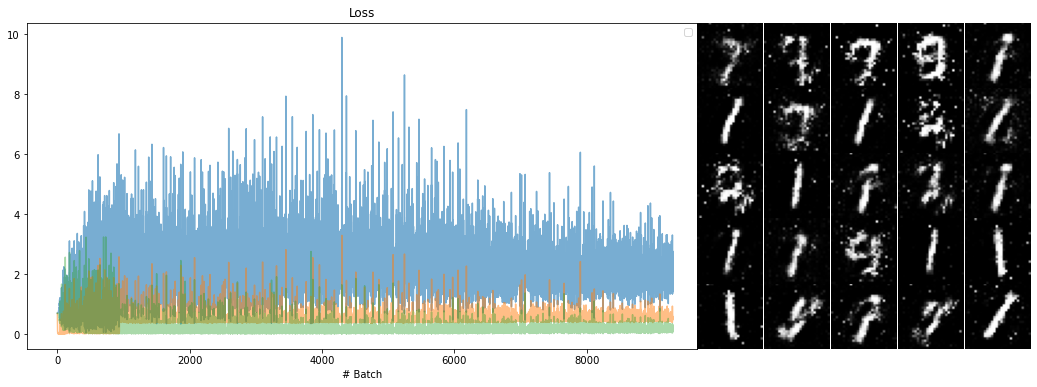

In [8]:
gan = GAN_MNIST()
gan.train()

#### Generate

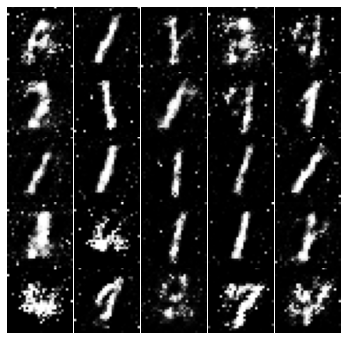

In [12]:
gan.generate_images(plot=True);

_Note: you can see an example for **mode collapse** due to the G generate mostly ONEs._

In [10]:
# Free GPU memory
del gan
torch.cuda.empty_cache()

#### Closing Thoughts
This implementation was about generating images and focus on:
* Architecture  
* Training loop  
* Visualization
* generate images
* Debbuging

While doing this in **PyTorch**. 

Actually, this was my **first time** working with images and NN. 

I know this GAN is very simple.
But it should be enough to get you started implementing more complex GANs in PyTorch.

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

# Goal #3 - Predator Prey dataset
Train a NN to fit the Predator-Prey cycle using GAN architecture.

#### imports - **This was my first time using keras!**

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm # from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.backend import sin,mean
from tensorflow.keras.layers import Input, Reshape, LeakyReLU, Activation, Dropout, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import TensorBoard

#### Hyper-Parameters

In [2]:
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 50000
XY = np.empty((2, steps))
XY[:,0] = 50, 100
dt = 0.001

#### Dataset

In [3]:
def get_rates(x, y, b, h, ϵ, d): ###
    return np.array([
      b*x,          # prey born
      (1-ϵ)*h*x*y,  # prey killed, no predator born
      ϵ*h*x*y,      # prey killed, predator born
      d*y,          # predator killed
    ])



def draw_time(rates): ###
#     assert rates.sum() > 0, rates
    return np.random.exponential( 1/rates.sum() )

def draw_reaction(rates): ###
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

updates = np.array([
  [ 1, 0],   # prey born
  [-1, 0],   # prey killed, no predator born
  [-1, 1],   # prey killed, predator born
  [ 0,-1],   # predator killed
])


def gillespie_step(x, y, b, h, ϵ, d): ###
    rates = get_rates(x, y, b, h, ϵ, d)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy = updates[ri]
    return Δt, Δx, Δy


def gillespie_ssa(b, h, ϵ, d, times_,t0=0, x0=50, y0=100, t_steps=steps, tmax=steps*dt,padding=False): ###
    xx = np.full(steps,0,dtype='int')
    yy = np.full(steps,0,dtype='int')

    t = 0
    i = 0
    xx[0] = x0
    yy[0] = y0

    while t<tmax and yy[i]!=0:
        
        if times_[i] <= t:
            i += 1
            xx[i] = xx[i-1]
            yy[i] = yy[i-1]
        else:
            # update
            Δt, Δx, Δy = gillespie_step(xx[i], yy[i], b, h, ϵ, d)

            t     = t+Δt
            xx[i] = xx[i]+Δx
            yy[i] = yy[i]+Δy

    if i <= steps and not padding:
        return np.array([times_[:i+1],xx[:i+1],yy[:i+1]])       
    else:
        return np.array([times_,xx,yy])

times = np.linspace(0, steps*dt, steps)
t,x,y = gillespie_ssa(b, h, ϵ, d,times_=times)


x_max,y_max = x.max(),y.max()
x_,y_ = x / x_max, y / y_max

# Sample function
def sample_data_pp(num=1000):
    indices = np.sort(np.random.choice(len(x_),num,replace=False))
    return np.array([np.array(x_[indices]),np.array(y_[indices])])

Let's check the sampling function for both Predator and Prey:

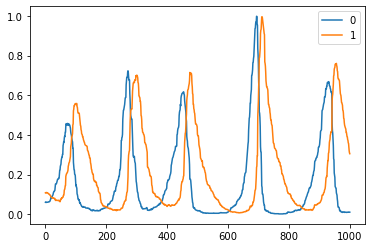

In [4]:
ax = pd.DataFrame(np.transpose(sample_data_pp())).plot()

Let me focus only on prey:

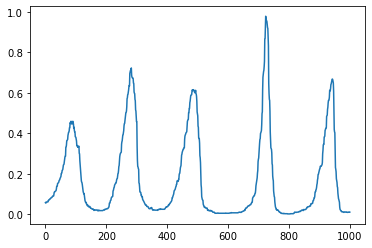

In [5]:
t = sample_data_pp(num=1000)
plt.plot(np.transpose(t[0]));

#### Generator

In [6]:
def create_G(num=100):
    G_in = Input(shape=15)
    x = Reshape((-1,1))(G_in)
    x = Conv1D(2,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(4,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(8,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(16,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(32,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(64,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(100,3,activation='tanh')(x)
    x = Flatten()(x)
    G = Model(G_in,x,name='Generator')
    G.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001))
    return G

G = create_G()
G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 15, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 2)             8         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 2)             8         
_________________________________________________________________
dropout (Dropout)            (None, 13, 2)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 4)             28        
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 4)             16

#### Discriminator

In [7]:
def create_D(num=100):
    D_in = Input(shape=num)
    x = Reshape((-1,1))(D_in)
    x = Conv1D(num/2,3,activation=LeakyReLU())(x)
    x = Conv1D(num/10,3,activation=LeakyReLU())(x)
    x = Conv1D(num/50,3,activation=LeakyReLU())(x)
    x = Flatten()(x)
    x = Dense(128,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(64,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(32,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(8,activation=LeakyReLU())(x)
    x = Dense(2,activation='sigmoid')(x)
    D = Model(D_in,x,name='Discriminator')
    D.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.003))
    return D

D = create_D()
D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 98, 50)            200       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 10)            1510      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 94, 2)             62        
_________________________________________________________________
flatten_1 (Flatten)          (None, 188)               0         
_________________________________________________________________
dense (Dense)                (None, 128)             

#### GAN

In [8]:
def create_GAN(G,D,num=100):
    D.trainable = False
    GAN_in = Input(shape=15)
    x = G(GAN_in)
    x = D(x)
    model = Model(GAN_in,x,name='GAN')
    model.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return model

GAN = create_GAN(G,D)
GAN.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
Generator (Functional)       (None, 100)               28120     
_________________________________________________________________
Discriminator (Functional)   (None, 2)                 36582     
Total params: 64,702
Trainable params: 27,868
Non-trainable params: 36,834
_________________________________________________________________


#### Sanity Check:
due to the complex of the model let me make sure all is working as expected:

In [9]:
data_temp = sample_data_pp(num=15)
print(data_temp.shape,G(data_temp).shape,D(G(data_temp)).shape,GAN(data_temp).shape)

(2, 15) (2, 100) (2, 2) (2, 2)


#### Train steps of D & G

In [10]:
noise_size = 15

# set layers on/off train
def trainable_D(D,trainable):
    D.trainable = trainable
    for layer in D.layers:
        layer.trainable = trainable

        
def train_D(GAN,G,D,on_pray=True):
    # samples size  (batch)
    batch_size = 15

    # set_trainability
    trainable_D(D,True)

    # create noise
    noise = np.abs(np.random.randn(batch_size,noise_size))

    # fake
    x_fake = G.predict(noise)
    y_fake = np.zeros((batch_size,2)) # 0.1 instead of 0 - to evoid mode collapse 
    y_fake[:,0] = 1                   # 0.9 instead of 1 - to evoid mode collapse 
    loss_fake = D.train_on_batch(x_fake,y_fake)

    # real - PREY
    if on_pray:
        x_real = np.array([sample_data_pp(num=100)[0] for i in range(batch_size)])
    else:
        x_real = np.array([sample_data_pp(num=100)[1] for i in range(batch_size)])
    
    y_real = np.zeros((batch_size,2)) # 0.1 instead of 0 - to evoid mode collapse 
    y_real[:,1] = 1                   # 0.9 instead of 1 - to evoid mode collapse 
    loss_real = D.train_on_batch(x_real,y_real)

    return loss_fake,loss_real

  

def train_G(GAN,G,D):

    # samples size  (batch)
    batch_size = 15

    # set_trainability
    G.trainable = True
    trainable_D(D,False)

    # create noise
    noise = np.abs(np.random.randn(batch_size,noise_size))

    # fake
    # x_fake = G.predict(noise)
    y_fake = np.zeros((batch_size,2))
    y_fake[:,1] = 1
    loss = GAN.train_on_batch(noise,y_fake)

    return loss

Sanity Check:

In [11]:
train_D(GAN,G,D), train_G(GAN,G,D)

((0.6930726766586304, 0.7439238429069519), 0.6872183680534363)

#### Train GAN

In [12]:
def train(GAN, G, D, epochs=100, n_samples=100, verbose=True):
    d_loss_fake = []
    d_loss_real = []
    g_loss = []
    e_range = range(epochs)
    
    if verbose:
        e_range = tqdm(e_range)
    
    for epoch in e_range:
        loss_fake,loss_real = train_D(GAN,G,D)
        d_loss_fake.append(loss_fake)
        d_loss_real.append(loss_real)
        
        loss = train_G(GAN,G,D)
        g_loss.append(loss)
        
        if verbose and ((epoch+1)%(epochs//10)==0):
            print("Epoch #{}:\t Generative Loss: {},    \t Discriminative Loss fake: {}, Discriminative Loss real: {}".format(epoch+1, g_loss[-1], d_loss_fake[-1], d_loss_real[-1]))
    return g_loss,d_loss_fake,d_loss_real

g_loss,d_loss_fake,d_loss_real = train(GAN, G, D, verbose=True)

Epoch #10:	 Generative Loss: 2.36905574798584,    	 Discriminative Loss fake: 0.015760576352477074, Discriminative Loss real: 0.0186001006513834
Epoch #20:	 Generative Loss: 13.932963371276855,    	 Discriminative Loss fake: 0.003945493139326572, Discriminative Loss real: 1.4132818250800483e-05
Epoch #30:	 Generative Loss: 20.495332717895508,    	 Discriminative Loss fake: 0.004247874021530151, Discriminative Loss real: 0.00016064960800576955
Epoch #40:	 Generative Loss: 18.873523712158203,    	 Discriminative Loss fake: 0.0483543686568737, Discriminative Loss real: 0.001071239123120904
Epoch #50:	 Generative Loss: 16.03032875061035,    	 Discriminative Loss fake: 0.017826693132519722, Discriminative Loss real: 0.08348666876554489
Epoch #60:	 Generative Loss: 6.583922386169434,    	 Discriminative Loss fake: 0.04926323890686035, Discriminative Loss real: 0.15698513388633728
Epoch #70:	 Generative Loss: 3.1525802612304688,    	 Discriminative Loss fake: 0.008090116083621979, Discriminat

Google Colab  <a href='https://colab.research.google.com/drive/1l5oPrs2bVY2Nuwx5MX4vJ6rPZv1Bfysw?usp=sharing'>Notebook</a> with **50K epochs**.
Due to my laptop's low computing power...

#### Generate

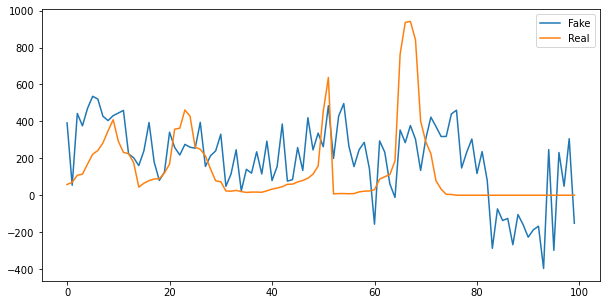

In [13]:
batch_size = 1

# create noise
noise = np.abs(np.random.randn(batch_size,noise_size))

# fake
x_fake = G.predict(noise)
y_fake = D.predict(x_fake)

# real
x_real = np.array([sample_data_pp(num=100)[0] for i in range(batch_size)])
y_real = D.predict(x_real)

plt.figure(figsize=(10,5))
plt.plot(np.transpose(x_fake*x_max),label='Fake')
plt.plot(np.transpose(x_real*x_max),label='Real')
plt.legend();
plt.show();

#### From Google Colab:
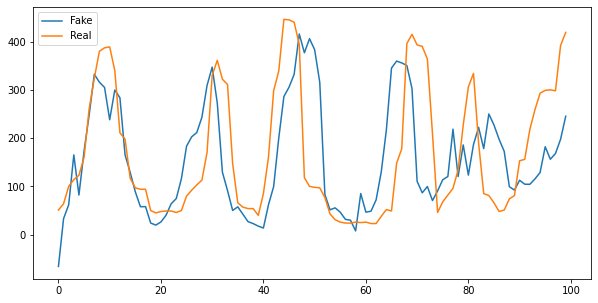

#### Closing Thoughts

This implementation was about implement GAN in Keras while using a more complex D & G architectures.
Actually, this was my first time working on signals.

I had hard time figuring it out, and probably invest too much time on checking for different architectures and way too much on training time.

Tried _Smoothing Target_ technique - 0.9 & 0.1 instead of 1 & 0  - but did not performed well.

**Here are a few references of my questions in the web:**


A whole <a href='https://piazza.com/class/k4lndg17jak1ef?cid=200'>conversation</a> with Yoav Ram on _piazza.com_

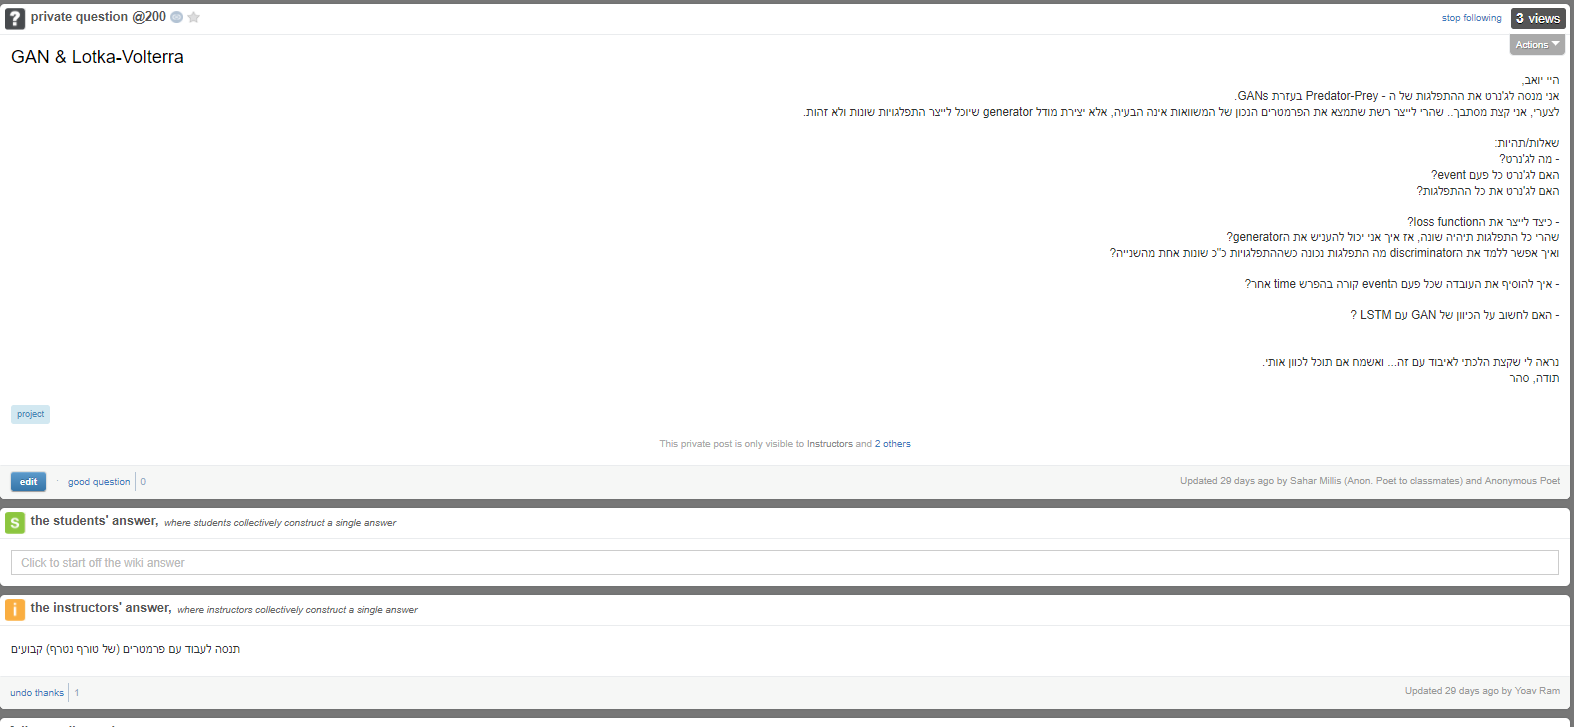

<a href='https://stackoverflow.com/questions/63456939/keras-discriminator-train-function-should-concatenate-the-fake-and-real'>question</a> in _stackoverflow.com_

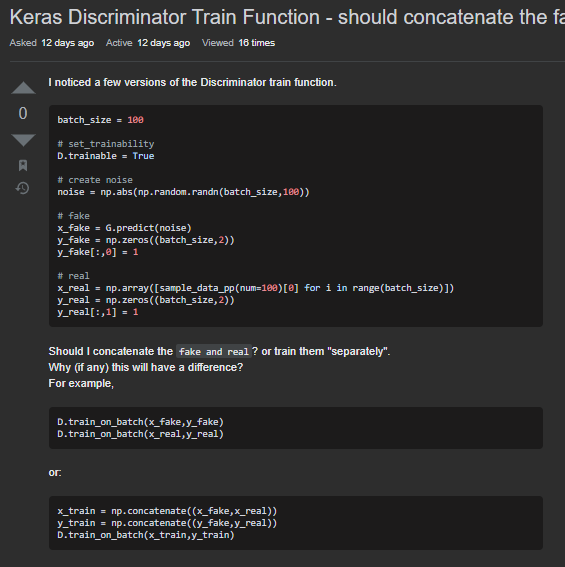

<a href='https://stackoverflow.com/questions/63460726/generate-series-of-values-using-keras-gan-architecture'>question</a> in _stackoverflow.com_

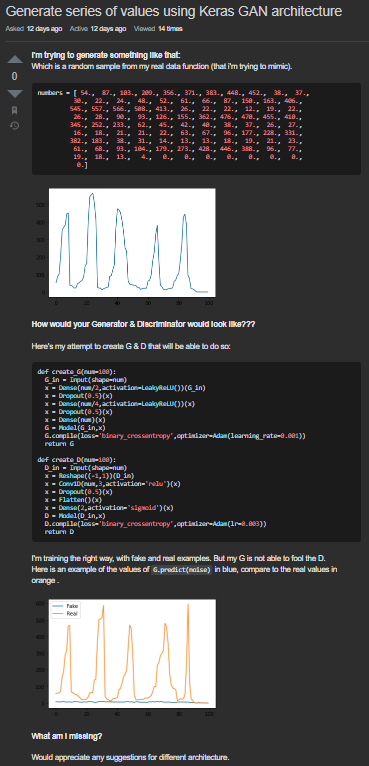

<a href='https://datascience.stackexchange.com/questions/80460/generate-series-of-values-using-keras-gan-architecture'>question</a> in _datascience.stackexchange.com_

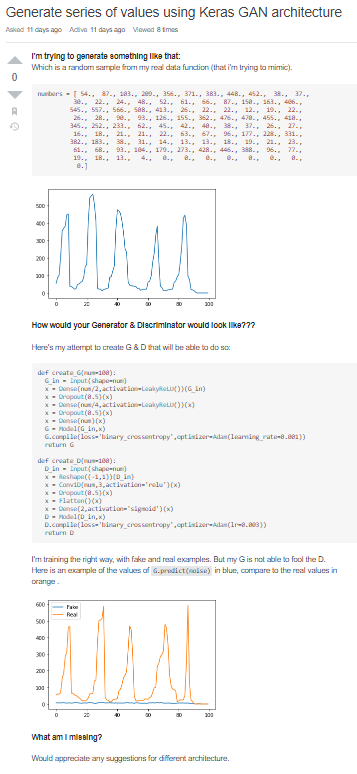

<a href='https://www.facebook.com/groups/999449923520287/?post_id=1975535732578363'>question</a> in _Facebook: Machine & Deep learning Israel_

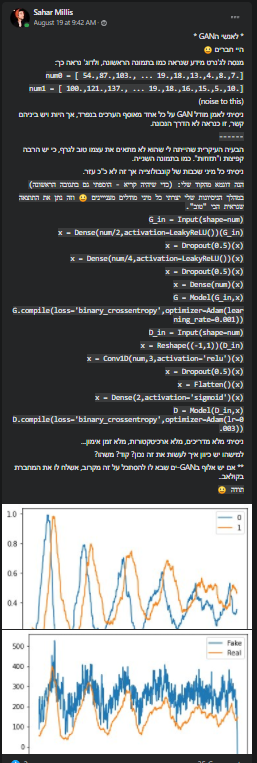

The answers for last question were a GAME CHANGER!
And polished my thinking.

<br><br>
<br><br>

First, the G should contains only **1D Conv layers**, but defenetly not Dense. 
Also, that there are GAN's architecture more suitable for this task like:  **DCGAN or WGAN** (which are the the improved versions of DCGAN), or WGAN-gp.

Also, got femiliar with these techniques, which should come handy while training GANs:  

* **Feature matching**  
Feature matching suggests to optimize the discriminator to inspect whether the generator’s output matches expected statistics of the real samples.   
In such a scenario, the new loss function can be any computation of statistics of features.   
For example, mean or median.   


* **Historical Averaging**  
This addition piece penalizes the training speed when Θ is changing too dramatically in time.  
It's basicly an moving avarage on the i & i-1 changin of the loss, with L2 norm. And uses as a regulator on the loss of the generator.   
This Will smooth out the noise and reduce the generator's variance.  


* **Batch Discrimination**  
With minibatch discrimination, the discriminator is able to digest the relationship between training data points in one batch, instead of processing each point independently.  
In one minibatch, we approximate the closeness between every pair of samples, and get the overall summary of one data point by summing up how close it is to other samples in the same batch.   


* **Adding Noises**  
To “spread out” the distribution and to create higher chances for two probability distributions to have overlaps.  
For example, One solution is to add continuous noises to the real examples of the discriminator D.  


* **G's L1**  
Use L1 Normalization on G's weights.  


* **Gradients Computetion Ratio**  
Compute the gradients of G & D with a different ratio.  
For example, on every train of G - train the D for 5 times.


* **Smoothing Target**  
When feeding the discriminator, instead of providing 1 and 0 labels - use soften values - Such as 0.9 and 0.1.   
It is shown to reduce the networks’ vulnerability.


* **Label Presentation**  
Train the model on a different label's presentations.   
For example, in this case - fourier transform.


* **Network Params**  
Play with all the params of the networks.   
for example, LR can have a huge affect and the "golden rule" G:0.0001 D:0.0004 is just a starting point.


* **Skip-z Connection**  
Feed the noise vector to additinal layers not just the first one.  
Very similar to attention in nlp.  
 

* **Better Metric of Distribution Similarity**  
The loss function of the vanilla GAN fails to provide a meaningful value when two distributions are disjoint.  
For example, instead of BCE loss use Wasserstein loss.


*To be honest, I'm not fully understand all of them - but I will !*

<br><br><br>
<br><br><br>
<br><br><br>

Following those instruction I decided to use some of them....
Here is my implementation of:

# WGAN 
with: 
- Better Metric of Distribution Similarity - Wasserstein Loss
- Clipping values (deleted due to my check - and it's not helpfull in this case)
- Gradients Computation Ratio - 1:5

and RMSprop Optimizer.

This is based on <a href='https://arxiv.org/abs/1701.07875'>Wasserstein GAN</a> article, and the recommended params.

#### Params

In [26]:
# hyper params
clip_value = 0.01
d_iterations = 5
noise_size = 15

# loss function
wasserstein_loss = lambda y_true,y_pred: mean(y_true * y_pred)

# optimizers
D_rmsprop_optimizer = RMSprop(lr=0.003)
G_rmsprop_optimizer = RMSprop(lr=0.001)

#### Generator

In [27]:
def create_G(num=100):
    G_in = Input(shape=noise_size)
    x = Reshape((-1,1))(G_in)
    x = Conv1D(2,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(4,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(8,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(16,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(32,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(64,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(100,3,activation='tanh')(x)
    x = Flatten()(x)
    G = Model(G_in,x,name='Generator')
    G.compile(loss=wasserstein_loss,optimizer=G_rmsprop_optimizer)
    return G

#### Discriminator

In [28]:
def create_D(num=100):
    D_in = Input(shape=num)
    x = Reshape((-1,1))(D_in)
    x = Conv1D(num/2,3,activation=LeakyReLU())(x)
    x = Conv1D(num/10,3,activation=LeakyReLU())(x)
    x = Conv1D(num/50,3,activation=LeakyReLU())(x)
    x = Flatten()(x)
    x = Dense(128,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(64,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(32,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(8,activation=LeakyReLU())(x)
    x = Dense(2,activation='sigmoid')(x)
    D = Model(D_in,x,name='Discriminator')
    D.compile(loss=wasserstein_loss,optimizer=D_rmsprop_optimizer)
    return D



#### GAN

In [29]:
def create_GAN(G,D,num=100):
    D.trainable = False
    GAN_in = Input(shape=15)
    x = G(GAN_in)
    x = D(x)
    model = Model(GAN_in,x,name='GAN')
    model.compile(loss=wasserstein_loss,optimizer=G_rmsprop_optimizer)
    return model

D = create_D()
G = create_G()
GAN = create_GAN(G,D)


#### Sanity check:

In [30]:
data_temp = sample_data_pp(num=noise_size)
print(data_temp.shape,G(data_temp).shape,D(G(data_temp)).shape,GAN(data_temp).shape,'\n')

data_temp = np.array([sample_data_pp(num=noise_size)[0] for i in range(3)])
print(data_temp.shape,G(data_temp).shape,D(G(data_temp)).shape,GAN(data_temp).shape,GAN(data_temp))

(2, 15) (2, 100) (2, 2) (2, 2) 

(3, 15) (3, 100) (3, 2) (3, 2) tf.Tensor(
[[0.49979892 0.50006527]
 [0.49958935 0.50012887]
 [0.4998009  0.500094  ]], shape=(3, 2), dtype=float32)


#### Train

In [31]:
def train(GAN, G, D, epochs=100, n_samples=100, verbose=True):
    d_loss_fake = []
    d_loss_real = []
    g_loss = []
    e_range = range(epochs)
    
    if verbose:
        e_range = tqdm(e_range)
    
    for epoch in e_range:
        
        # ratio 1:d_iterations
        for _ in range(d_iterations)
            loss_fake,loss_real = train_D(GAN,G,D)
            d_loss_fake.append(loss_fake)
            d_loss_real.append(loss_real)
            
            # clipping - DID NOT BETTER THE RESULTS!
            #  for l in D.layers:
            #      weights = l.get_weights()
            #      weights = [np.clip(w, -clip_value, clip_value) for w in weights]
            #      l.set_weights(weights)
            
        
        loss = train_G(GAN,G,D)
        g_loss.append(loss)
        
        if verbose and ((epoch+1)%(epochs//10)==0):
            print("Epoch #{}:\t Generative Loss: {},    \t Discriminative Loss fake: {}, Discriminative Loss real: {}".format(epoch+1, g_loss[-1], d_loss_fake[-1], d_loss_real[-1]))
    return g_loss,d_loss_fake,d_loss_real

g_loss,d_loss_fake,d_loss_real = train(GAN, G, D, verbose=True)

Epoch #10:	 Generative Loss: 6.0203642533451784e-06,    	 Discriminative Loss fake: 0.0018407832831144333, Discriminative Loss real: 2.2949980120756663e-05
Epoch #20:	 Generative Loss: 2.042167034232989e-05,    	 Discriminative Loss fake: 5.623669530052666e-09, Discriminative Loss real: 3.909691076842137e-05
Epoch #30:	 Generative Loss: 1.0391713090029953e-07,    	 Discriminative Loss fake: 5.180550601835421e-07, Discriminative Loss real: 2.0096564412597218e-08
Epoch #40:	 Generative Loss: 9.927385580255077e-10,    	 Discriminative Loss fake: 2.2724374397725504e-14, Discriminative Loss real: 3.4924175906780874e-06
Epoch #50:	 Generative Loss: 3.294523776276037e-05,    	 Discriminative Loss fake: 9.14520629363702e-12, Discriminative Loss real: 3.39728565279529e-08
Epoch #60:	 Generative Loss: 2.910423638202708e-13,    	 Discriminative Loss fake: 8.911027840098618e-14, Discriminative Loss real: 1.9262075511505827e-05
Epoch #70:	 Generative Loss: 1.4306415688940514e-19,    	 Discriminativ

Google Colab  <a href='https://colab.research.google.com/drive/1B6RpRg-c5TxiX8J7KhJaFa1235fagNIe?usp=sharing'>Notebook</a> with **50K epochs**.
Due to my laptop's low computing power...

#### Generate

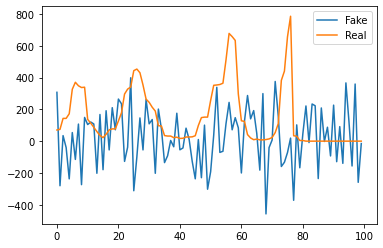

In [32]:
batch_size = 1

# create noise
noise = np.abs(np.random.randn(batch_size,noise_size))

# fake
x_fake = G.predict(noise)
y_fake = D.predict(x_fake)

# real
x_real = np.array([sample_data_pp(num=100)[0] for i in range(batch_size)])
y_real = D.predict(x_real)

# plt.figure(figsize=(15,6))
plt.plot(np.transpose(x_fake*x_max),label='Fake')
plt.plot(np.transpose(x_real*x_max),label='Real')
plt.legend();
plt.show();

#### From Google Colab:
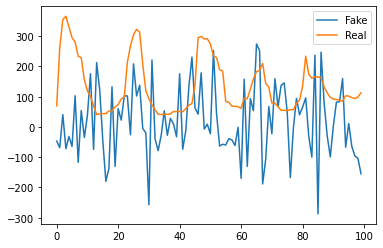

#### Closing Thoughts
This implementation was about implement a different known kind of GAN, Focusing on techniques such as:
* Improved Metric
* Clipping Values  
* Gradients Ratio

While doing this in **Keras**. 
I can only assume it did not work well to my lack of knowledge in signals and the lack of experience in GANs.

<br><br><br>
<br><br><br>
<br><br><br>

**It's everywhere...**

The _**Mode collapse**_ problem where described in every article/blog/post about GANs.

Explanation:
*During the training, the generator may collapse to a setting where it always produces same outputs. This is a common failure case for GANs, commonly referred to as Mode Collapse. Even though the generator might be able to trick the corresponding discriminator, it fails to learn to represent the complex real-world data distribution and gets stuck in a small space with extremely low variety.*

I can only assumed that one of this models had this problem, but due to my inexperience, I could not reconize that this was the issue.

However, You can see a model collapse example in my MNIST's Generator, due to it's preferece of generating mostly ONEs.  

<br><br><br>

**GANs: Keras vs PyTorch**

My persenal opinion is that pytorch is a much better framework to train GANs on, mostly due to:
* My control over the farward pass
* Efiecient training proccess
* Debbuging

For example, I added a few improvements to the momery consemption & visualization.
But in the other hand, the Keras code is shorted and allows my to design the G/D layers must faster.

To each his own :)

<br><br><br>

# FINAL CONCLUSION

The training proccess was't time consuming as the on _reshaping the data_ and _debugging pytorch errors_.   

Also, I had _no prior knowledge on Images data or signals data._   
For example, still struggling with the Channels in the CONV layer.

The predator prey model wasn't a success (to say the least), but I happy with the _experience_ I got from this task.

**While having a hard time on this project, I had fun, felt challanged and learned a lot.**

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

# References:  

<br><br>

**Articles**  
<br>
<a href='https://arxiv.org/pdf/1701.04862.pdf'>TOWARDS PRINCIPLED METHODS FOR TRAINING
GENERATIVE ADVERSARIAL NETWORKS</a>  

<a href='https://arxiv.org/pdf/2004.05803.pdf'>Adversarial Likelihood-Free Inference on Black-Box Generator
</a>  

<a href='http://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf'>Improved Techniques for Training GANs</a> 

<br><br>

**Blog Posts:**  
<br>
<a href='https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b'>GAN — Ways to improve GAN performance</a>  

<a href='https://www.tensorflow.org/tutorials/quickstart/advanced'>TensorFlow 2 quickstart for experts</a>  

<a href='https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html'>from GAN to WGAN</a>  

<br><br>

**GitHub:**   
<br>
<a href='https://github.com/yoavram/DataSciPy/blob/master/sessions/GAN.ipynb'>GitHub: yoavram/DataSciPy/GAN</a>  

<a href='https://github.com/eriklindernoren/PyTorch-GAN'>PyTorch-GAN
</a>  

<a href='https://github.com/eriklindernoren/Keras-GAN'>Keras-GAN
</a>  

<br><br>

**YouTube:**
<br>
<a href='https://www.youtube.com/watch?v=Z6rxFNMGdn0'>Ian Goodfellow: Generative Adversarial Networks (GANs) | Lex Fridman Podcast </a>

<a href='https://www.youtube.com/watch?v=HGYYEUSm-0Q'>Ian Goodfellow: Generative Adversarial Networks (NIPS 2016 tutorial)
</a>


<a href='https://www.youtube.com/watch?v=vi7lACKOUao'>Deep Learning Chapter 1 Introduction presented by Ian Goodfellow
</a>  

<a href='https://www.youtube.com/watch?v=9JpdAg6uMXs'>Introduction to GANs, NIPS 2016 | Ian Goodfellow, OpenAI
</a>  

